# Modelling LSTM with Raw and Scaled Data

## Load Dataset

In [1]:
import pandas as pd
df = pd.read_csv('../data/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
...,...
2023-08-04 20:00:00+00:00,94.00
2023-08-04 21:00:00+00:00,91.70


## Data Preprocessing

### Scale Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)
data_raw = df.values

### Train Test Split

In [3]:
train_raw, test_raw = train_test_split(data_raw, test_size=0.2, shuffle=False)
train_scaled, test_scaled = train_test_split(data_scaled, test_size=0.2, shuffle=False)

### Create Sequences

In [4]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24 # Use 24 hours prior to predict the following hour
X_train_raw, y_train_raw = create_sequences(train_raw, sequence_length)
X_test_raw, y_test_raw = create_sequences(test_raw, sequence_length)

X_train_scaled, y_train_scaled = create_sequences(train_scaled, sequence_length)
X_test_scaled, y_test_scaled = create_sequences(test_scaled, sequence_length)

## Modelling

In [5]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

from sklearn.metrics import mean_squared_error

### Raw Data

In [6]:
import tensorflow as tf
from keras.utils import set_random_seed

set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [7]:
model_raw = Sequential(layers=[
    Input(shape=(X_train_raw.shape[1], X_train_raw.shape[2])),
    LSTM(50),
    Dense(1)
])

model_raw.compile(optimizer='adam', loss='mean_squared_error')

history_raw = model_raw.fit(
    X_train_raw, y_train_raw, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test_raw, y_test_raw), callbacks=[early_stop])

In [8]:
history_raw.history

{'loss': [14989.6806640625,
  11894.8369140625,
  9860.916015625,
  8222.421875,
  6866.01123046875,
  5737.85498046875,
  4796.57275390625,
  4007.109130859375,
  3345.275634765625,
  2793.215576171875,
  2335.788818359375,
  1959.74609375,
  1651.0126953125,
  1400.6121826171875,
  1198.3262939453125,
  1032.7847900390625,
  895.3369750976562,
  786.8594970703125,
  696.5238037109375,
  620.0357055664062,
  559.2014770507812,
  504.60888671875,
  459.0068359375,
  418.5453796386719,
  384.4638977050781,
  355.6593017578125,
  327.3274841308594,
  305.2088317871094,
  283.5623779296875,
  264.59112548828125],
 'val_loss': [6353.21923828125,
  4468.9609375,
  3103.15185546875,
  2104.748779296875,
  1396.305908203125,
  917.5978393554688,
  603.9852294921875,
  400.1684875488281,
  278.00958251953125,
  209.3993682861328,
  174.4014129638672,
  156.64315795898438,
  152.72628784179688,
  146.44876098632812,
  143.07424926757812,
  133.303955078125,
  132.33871459960938,
  128.209365844

### Scaled Data

In [9]:
import tensorflow as tf
from keras.utils import set_random_seed

set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [10]:
model_scaled = Sequential(layers=[
    Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(50),
    Dense(1)
])

model_scaled.compile(optimizer='adam', loss='mean_squared_error')

history_scaled = model_scaled.fit(
    X_train_scaled, y_train_scaled, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stop])

### Compare History

In [11]:
import sys
sys.path.append('../')

In [12]:
import utils

df_history = utils.process_df_history(history_raw, history_scaled)
df_history

,variable,value
epoch,,
0,raw,14989.680664
1,raw,11894.836914
...,...,...
48,scaled,0.000168
49,scaled,0.000168


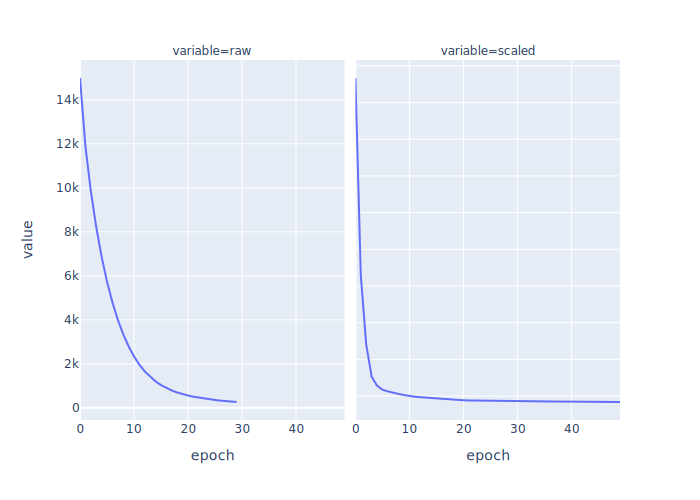

In [13]:
import plotly.express as px

fig = px.line(data_frame=df_history, x=df_history.index, y='value', facet_col='variable')
fig.update_yaxes(matches=None)

### Predictions

In [14]:
y_pred_raw = model_raw.predict(X_test_raw)

y_pred_scaled = model_scaled.predict(X_test_scaled)
y_pred_scaled_inverse = scaler.inverse_transform(y_pred_scaled)

  1/197 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step

 51/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

109/197 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step

166/197 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1/197 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step

 55/197 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step

115/197 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step

172/197 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


#### Create DataFrame

In [15]:
import utils

dic_pred = {
    'y_true': y_test_raw,
    'y_pred_raw': y_pred_raw,
    'y_pred_scaled': y_pred_scaled,
    'y_pred_scaled_inverse': y_pred_scaled_inverse
}

df_pred = utils.process_df_pred(df, y_test_raw, dic_pred)
df_pred

/Users/sota/Library/CloudStorage/Dropbox/2 Business/1 Datons/2 Areas/Courses/22 TS/solutions-new/notebooks/60_Forecasting II Deep Learning/5_Raw vs Scaled/../utils.py:10: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



,y_true,y_pred_raw,y_pred_scaled,y_pred_scaled_inverse
2022-11-15 22:00:00+00:00,105.00,120.572891,0.176569,123.598396
2022-11-15 23:00:00+00:00,90.52,97.767250,0.142898,100.028641
...,...,...,...,...
2023-08-04 20:00:00+00:00,94.00,93.772896,0.134413,94.089241
2023-08-04 21:00:00+00:00,91.70,89.533813,0.130322,91.225449


#### Visualize Data

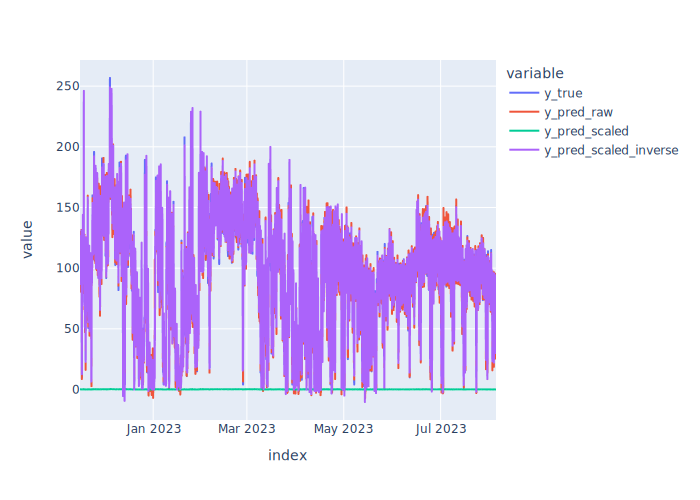

In [16]:
utils.plot_df(df_pred)

In [17]:
df_pred_2 = df_pred.loc['2023-08-02':].copy()
df_pred_2

,y_true,y_pred_raw,y_pred_scaled,y_pred_scaled_inverse
2023-08-02 00:00:00+00:00,96.09,95.172005,0.137127,95.988922
2023-08-02 01:00:00+00:00,96.09,95.482315,0.138568,96.997398
...,...,...,...,...
2023-08-04 20:00:00+00:00,94.00,93.772896,0.134413,94.089241
2023-08-04 21:00:00+00:00,91.70,89.533813,0.130322,91.225449


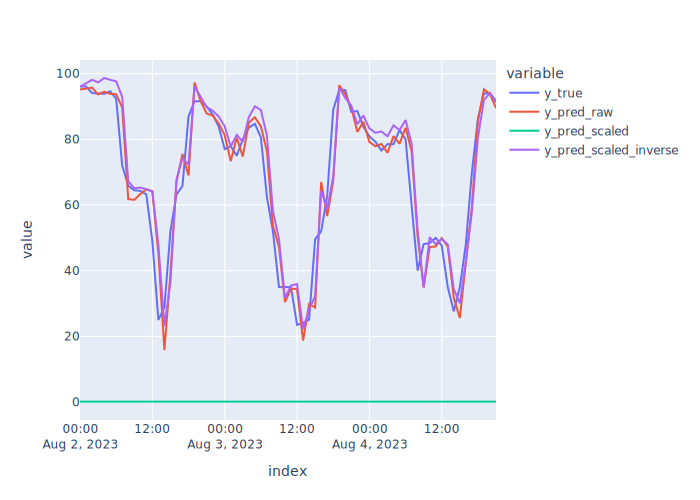

In [18]:
utils.plot_df(df_pred_2)

### Evaluation

In [19]:
mean_squared_error(y_test_raw, y_pred_scaled_inverse, squared=False)

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



10.987225595050807

In [20]:
mean_squared_error(y_test_raw, y_pred_raw, squared=False)

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



11.032081789707014